In [25]:
"""Author: Faramarz Munshi CS271
TODO:
      1. Make Graphics look better :)
"""

import matplotlib.pyplot as plt
import numpy as np

class Othello():    
    
    def __init__(self, turn, board_state, AI, MAX_DEPTH=10):
        """" Initialize the board and state of the game
            Args:
                turn: Whether it is white or black's turn
                board_state: the chararray filled with 'w' for white, 'b' for black,
                and 'e' for empty representing the current board state. 
                AI: whether white or black is the AI
        """
        self.MAX_DEPTH = MAX_DEPTH
        # If the board state is given at instantiation, set it as the current
        # board state, otherwise instantiate normal starting position
        
        if type(board_state) == np.chararray:
            self.board_state = board_state
        else:
            self.board_state = np.chararray((8,8))
            self.board_state[:] = b'e'
            self.board_state[3][3] = b'b'
            self.board_state[4][3] = b'w'
            self.board_state[3][4] = b'w'
            self.board_state[4][4] = b'b'
        
        # If whose turn is given at instantiation, set it, otherwise default
        # to black
        
        if turn== b'w' or turn== b'b':
            self.turn=turn
        else:
            self.turn = b'b'
        
        # If which person is AI is given, set it, otherwise default
        # to white
        
        if AI == b'w' or AI == b'b':
            self.AI = AI
        else:
            self.AI = b'w'

        print("""Welcome to the Game of Othello! Your configurations are as follows: 
                1. It is {0}\'s turn first with the AI playing as {1}
                2. Max depth of the tree for minimax with alpha beta pruning is {2}.
                
                The white are white pieces, black are blacks, and the X's are the
                moves you or the AI can make on that turn.
                (0,0) is the bottom left of the board. Please do a turn by using
                the do_turn(x, y) method where x is the x coordinate, and y is the y
                coordinate of the move you would like to make.
                The board will refresh twice every do_turn iteration, once for the human's
                turn and once for the AI. Good Luck!
                """.format(turn, AI, MAX_DEPTH))
        print(self)
    
    def do_turn(self, x, y):
        """ Do a single black or white turn
            Args:
                x: x coordinate of the move desired to make
                y: y coordinate of the move desired to make
            Does not return anything! This should only be used to update the MAIN GAME BOARD.
        """
        # make a tuple move as concatenation of x and y
        move = (x,y)
        
        # get a list of all the valid moves at this board state
        valid_moves = self.get_valid_moves()

        if not valid_moves:
            print("No moves are valid! Swapping to the other's turn.")
            if self.turn == b'b':
                    self.turn = b'w'
            else:
                    self.turn = b'b'
        else:
            # Check if the move that the person is trying to make is valid

            if move not in valid_moves:
                print("Inputted move not valid!")
            else:
                # If the move is valid, and it's the AI's turn, update the board
                # with the move, and swap the turn to the other person
                if self.turn==self.AI:
                    self.board_state = self.update_board(x, y)
                    print("Your turn!")
                    if self.turn == b'b':
                        self.turn = b'w'
                    else:
                        self.turn = b'b'
                # If the move is valid, and it's NOT the AI's turn, update the board
                # with the new move and switch to AI's turn

                elif self.turn != self.AI:
                    print("You moved!")
                    self.board_state = self.update_board(x, y)
                    print("AI\'s Turn!")

                    # find the best move the computer can make
                    self.turn = self.AI
                    move = self.get_best_move()
                    if (move is not None):
                        self.do_turn(move[0], move[1])   
                else:
                    print('Something went seriously wrong to get here.')

        # if there are no valid moves, change turn to other person's turn
        if self.is_goal_state():
            print ("Game Over!")
            white, black = self.get_score()
            if white > black:
                print ("White wins!")
            if black > white:
                print ("Black wins!")
        
    def get_score(self, board_state = None):
        """ Get the current scores for white and black and return them
            Args:
                board_state = the current or inputted board state for which to find score
            Returns:
                white = number of white pieces
                black = number of black pieces
        """
        if not type(board_state) == np.chararray:
            board_state = self.board_state
        white = 0
        black = 0
        for i in range(len(board_state)):
            for j in range(len(board_state[i])):
                # Iterate through all board positions and increment a counter for white and black

                if board_state[i][j] == b'w':
                    white+=1
                elif board_state[i][j] == b'b':
                    black+=1
                else:
                    continue
        return white, black

    def update_board(self, x, y, board_state = None, turn=None):
        """ Update the board with the new move and all of the changes
            that happen as a result of the move
            Args:
                x: x position of the move
                y: y position of the move
            Returns:
                board_state: updated state of the board after the move.
        """
        if not type(board_state) == np.chararray:
            board_state = self.board_state
            to_print = True
        else:
            to_print = False
        if not turn:
            turn = self.turn

        # Define the eight vectors you can move from one square

        directions = [(0,1),(0,-1),(1,0),(1,1),(1,-1),(-1,0),(-1,-1),(-1, 1)]
        
        # Figure out whose turn it is
        board_state[x][y] = turn
        
        # Find out which directions need to be updated to a different colour
        need_to_be_updated = []
        # Iterate through all the directions and check them one at a time
        for d in directions:
            move_found = False
            
            # check_spot is our placeholder for the first spot in the direction
            check_spot = tuple(map(sum, zip((x,y),d)))
            
            # start a separate list to keep adding positions that are the other
            # colour as the one we started out with until we hit the
            # same colour as we started with
            may_need_to_be_updated = [check_spot]
            
            # Check if the spot is out of bounds of the board, then whether
            # the colour of this next square in direction d is of the opposite colour
            if not self.isOOB(*check_spot) and board_state[check_spot[0]][check_spot[1]] != turn and board_state[check_spot[0]][check_spot[1]] != b'e':
                # Keep moving in the direction d, checking if it's OOB and what colour it is
                check_spot = tuple(map(sum, zip((check_spot[0],check_spot[1]),d)))
    
                may_need_to_be_updated.append(check_spot)
                while not self.isOOB(*check_spot) and not move_found:
                    check_spot_colour = board_state[check_spot[0]][check_spot[1]]
                    # If the next next or next*3... spot in the direction is the same colour as
                    # whose turn it is, we know that's the end of the move and can update all
                    # of their colours
                    if check_spot_colour == turn:
                        move_found = True
                        # get out of the while loop and change the may need to be updated
                        # into definitely need to be updated
                        need_to_be_updated+=may_need_to_be_updated
                    elif check_spot_colour == b'e':
                        # If we find an empty spot, the updating shouldnt have gone 
                        # in that direction, so we just move on to the next direction
                        move_found = True
                    else:
                        # If it's still of the opposite colour, move onto the next spot
                        # in that direction and check for the above conditions all over
                        # again
                        check_spot = tuple(map(sum, zip((check_spot[0],check_spot[1]),d)))
                        may_need_to_be_updated.append(check_spot)

            # If the spot isn't of opposite colour, move on to next direction
            else:
                continue
        for i, j in need_to_be_updated:
            board_state[i][j] = turn
        
        if to_print:
            print(self)
        return board_state
    
    def get_valid_moves(self, board_state=None, turn = None):
        """ Check current board state and see what moves are valid
        """
        
        # Define the eight vectors you can move from one square
        if not type(board_state) == np.chararray:
            board_state = self.board_state
        if not turn:
            turn = self.turn
        directions = [(0,1),(0,-1),(1,0),(1,1),(1,-1),(-1,0),(-1,-1),(-1, 1)]
        valid_moves = []
        
        # Set the x_bound and y_Bound to how big the board is
        y_bound = board_state.shape[1]
        x_bound = board_state.shape[0]
        
        # Iterate through the board finding empty positions and from every
        # empty position, search through the directions for the same colour
        for i in range(0, x_bound):
            for j in range(0, y_bound):
                if board_state[i][j] == b'e':
                    # search all directions for each empty spot
                    for d in directions:
                        move_found = False
                        # check_spot is our placeholder for the first spot in the direction
                        check_spot = tuple(map(sum, zip((i,j),d)))
                        
                        # Check if the spot is out of bounds of the board, then whether
                        # the colour of this next square in direction d is of the opposite colour
                        if not self.isOOB(*check_spot) and board_state[check_spot[0]][check_spot[1]] != turn and board_state[check_spot[0]][check_spot[1]] != b'e':
                            check_spot = tuple(map(sum, zip((check_spot[0],check_spot[1]),d)))
                            # Keep moving in the direction d, checking if it's OOB and what colour it is
                            
                            while not self.isOOB(*check_spot) and not move_found:
                                check_spot_colour = board_state[check_spot[0]][check_spot[1]]
                                if check_spot_colour == turn:
                                    move_found = True
                                    # If the next next or next*3... spot in the direction is the same colour as
                                    # whose turn it is, we know that's the end of the move and can add the move
                                    # to our list of valid moves
                                    valid_moves.append((i,j))
                                elif check_spot_colour == b'e':
                                    move_found = True
                                    # If we find an empty cell before we find our same colour,
                                    # the move is a dead-end and we move to next direction
                                else:
                                    # If none of the above happens, that means we can keep looking
                                    # in that direction until one of the top three things happen
                                    check_spot = tuple(map(sum, zip((check_spot[0],check_spot[1]),d)))
                else:
                    continue
        
        # return all the valid moves we gathered and deduplicate
        return list(set(valid_moves))

    def is_goal_state(self, board_state=None, turn=None):
        """ Checks if goal state has been reached by checkign for valid moves, then swapping
            turn and checking if the other player has any valid moves.
            Args:
                board_state = board state of the game or whatever board state you want
                turn = whoever's turn you want to check first
        """
        if not type(board_state) == np.chararray:
            board_state = self.board_state
        if not turn:
            turn = self.turn
        valid_moves = self.get_valid_moves(board_state=board_state, turn=turn)
        if valid_moves:
            return False
        else:
            if turn == b'w':
                turn = b'b'
                valid_moves = self.get_valid_moves(board_state=board_state, turn=turn)
                if valid_moves:
                    return False
                else:
                    return True
            else:
                turn = b'w'
                valid_moves = self.get_valid_moves(board_state=board_state, turn=turn)
                if valid_moves:
                    return False
                else:
                    return True
        
    def isOOB(self, x, y):
        """Given an x and y, check if the coordinates are inbounds or out
            Args:
                x: the x coordinate of the move
                y: the y coordinate of the move
            Returns:
                True if out of bounds of board
                False if in bounds of board
        """
        
        y_bound = self.board_state.shape[1]
        x_bound = self.board_state.shape[0]
        if (x < x_bound and y < y_bound and x >= 0 and y >= 0):
            return False
        else:
            return True
            
    
    def get_best_move(self):
        """ Standard Minimax Algorithm 
            Args: None
            Returns:
                best_move: best move based on score and minimaxing
        """
        import copy
        # Create a copy of the world so we don't affect the main board
        start_state = copy.deepcopy(self.board_state)
        infinity = float('inf')
        best_val = -infinity
        beta = infinity
        # Call max_value on the current state of the board
        best_move, best_val = self.max_value(start_state, best_val, beta)

        # Return the best move
        print("The AI concluded that {0} is the best move.".format(best_move))
        return best_move

    def max_value(self, board_state, alpha, beta, depth=0):
        """ Returns the max value at a specific depth, iteratively calls min_value.
            Args:
                board_state: state of the game you want to maximize
                depth: how far deep into the tree we want to go
            Returns:
                Can return 2 different outputs depending on depth
                if depth is 0, it returns the best move and the max value
                otherwise it just returns the max value
        """
        # Check if goal state has been reached or the max_depth we want to traverse has been
        # reached, if so, return the score as if it were a child node.

        if self.is_goal_state(board_state) or depth >= self.MAX_DEPTH:
            white, black = self.get_score(board_state)
            if self.AI==b'w':
                score = white-black
            if self.AI==b'b':
                score = black-white
            return (0,0), score
        # Default max value is negative infinity for any new node
        infinity = float('inf')
        value = -infinity
        max_values = []
        # check which moves are valid for the AI to maximize
        successor_moves = self.get_valid_moves(board_state=board_state, turn=self.AI)

        # iterate through all the moves 
        for move in successor_moves:
            x = move[0]
            y = move[1]
            # create a new board state after each move happened, and call min_value on the
            # next turn to minimize the players gain.
            new_board_state = self.update_board(x, y, board_state=board_state, turn=self.AI)
            value = max(value, self.min_value(new_board_state, alpha, beta, depth=depth+1))
            if value >= beta and depth != 0:
                return move, value
            if value >= beta and depth == 0:
                return move, value
            alpha = max(alpha, value)
            max_values.append(self.min_value(new_board_state, alpha, beta, depth=depth+1))
            if max_values[-1] >= beta and depth != 0:
                return move, max_values[-1]
            if max_values[-1] >= beta and depth==0:
                return move, max_values[-1]
            alpha = max(alpha, max_values[-1])
            # check if max_values is last entry on the list, and if it is, assign best_move
            # as that move
            if max(max_values) == max_values[-1]:
                best_move = move
        # check how deep we are into the tree, if we are at surface depth, return the best move
        # and the max value of that move, otherwise return the max value we found
        if depth == 0 and max_values:
            return best_move, max(max_values)
        elif depth != 0 and max_values:
            return best_move, max(max_values)
        else:
            return (0,0), value

    def min_value(self, board_state, alpha, beta, depth=0):
        """ Returns the min value at a specific depth, iteratively calls max_value.
            Args:
                board_state: state of the game you want to minimize
                depth: how far deep into the tree we want to go
            Returns:
                min_value: minimum value of node at depth
        """
        # Check if goal state has been reached or the max_depth we want to traverse has been
        # reached, if so, return the score as if it were a child node.

        if self.is_goal_state(board_state) or depth >= self.MAX_DEPTH:
            white, black = self.get_score(board_state)
            if self.AI==b'w':
                score = white-black
            if self.AI==b'b':
                score = black-white
            return score

        # Default min value is infinity for any new node

        infinity = float('inf')
        value = infinity
        
        # Set the turn to be the human person's turn, so we can test all possible moves
        # he/she can do
        if self.AI == b'w':
            turn = b'b'
        elif self.AI == b'b':
            turn = b'w'

        # get all the moves that the human person could possibly do
        successor_moves = self.get_valid_moves(board_state=board_state, turn=turn)

        # iterate through all of them and find which minimizes their score
        for move in successor_moves:
            x = move[0]
            y = move[1]
            # create a new board state for every move and find the minimum out of all of them
            new_board_state = self.update_board(x, y, board_state=board_state, turn=turn)
            move, new_val = self.max_value(new_board_state, alpha, beta, depth=depth+1)
            value = min(value, new_val)
            if value <= alpha:
                return value
            beta = min(beta,value)
        
        # return the minimum value
        return value
    
    def __repr__(self):
        to_return = 'Game of Othello with board position:\n {0}'.format(self.board_state)
                    
        return to_return
    def __str__(self):
        """ Print 'Game of Othello' and then display the current board state
            with pyplot
        """
        valid_moves = self.get_valid_moves()

        to_return = 'Game of Othello; Current Valid Moves are: ' + str(valid_moves)

        # Figure out board bounds
        y_bound = self.board_state.shape[1]
        x_bound = self.board_state.shape[0]

        # Draw the figure and axes so that the points will fall between grid lines on the plot
        fig = plt.figure()
        ax = fig.gca()
        ax.set_xticks(np.arange(-.5,8.5,1))
        ax.set_yticks(np.arange(-.5,8.5,1))

        # disable labels on the ticks
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        # set the colour of the background to green
        ax.set_facecolor('forestgreen')

        # Fill in all the black squares with a black dot, white with a white dot
        for i in range(0, x_bound):
            for j in range(0, y_bound):
                colour = self.board_state[i][j]
                if colour!=b'e':
                    if colour==b'w':
                        colour = 'white'
                    if colour==b'b':
                        colour = 'black'
                    plt.plot(i, j, marker='o', color=colour, markersize=20)
                else:
                    if (i,j) in valid_moves:
                        plt.plot(i,j, marker='x', color='plum', markersize=23)

        # Make sure to display the grid so you can see the spaces clearly demarcated
        plt.grid(True)
        # Make sure the axis is correctly scaled
        plt.axis([-.5,7.5,-.5,7.5])
        plt.show()
        return to_return

Welcome to the Game of Othello! Your configurations are as follows: 
                1. It is b'b''s turn first with the AI playing as b'w'
                2. Max depth of the tree for minimax with alpha beta pruning is 10.
                
                The white are white pieces, black are blacks, and the X's are the
                moves you or the AI can make on that turn.
                (0,0) is the bottom left of the board. Please do a turn by using
                the do_turn(x, y) method where x is the x coordinate, and y is the y
                coordinate of the move you would like to make.
                The board will refresh twice every do_turn iteration, once for the human's
                turn and once for the AI. Good Luck!
                


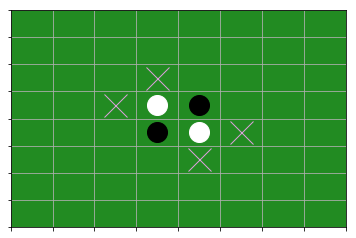

Game of Othello; Current Valid Moves are: [(4, 2), (2, 4), (5, 3), (3, 5)]


In [26]:
o = Othello(turn=b'b', board_state='', AI=b'w')


[(4, 2), (2, 4), (5, 3), (3, 5)]
You moved!


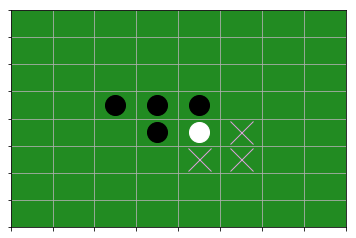

Game of Othello; Current Valid Moves are: [(4, 2), (5, 2), (5, 3)]
AI's Turn!
The AI concluded that (2, 5) is the best move.


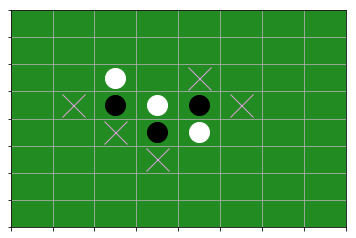

Game of Othello; Current Valid Moves are: [(4, 5), (5, 4), (3, 2), (2, 3), (1, 4)]
Your turn!


In [27]:
print(o.get_valid_moves())
o.do_turn(2,4)

You moved!


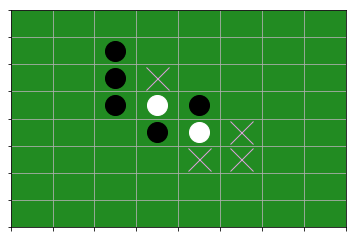

Game of Othello; Current Valid Moves are: [(4, 2), (5, 2), (5, 3), (3, 5)]
AI's Turn!
The AI concluded that (2, 3) is the best move.


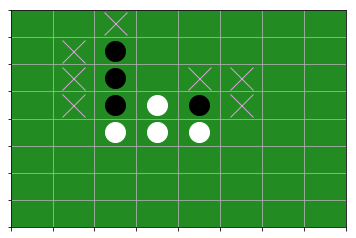

Game of Othello; Current Valid Moves are: [(2, 7), (5, 4), (5, 5), (4, 5), (1, 4), (1, 5), (1, 6)]
Your turn!


In [28]:
o.do_turn(2,6)

You moved!


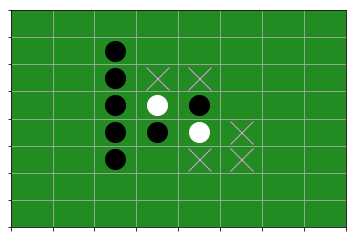

Game of Othello; Current Valid Moves are: [(4, 5), (4, 2), (5, 2), (5, 3), (3, 5)]
AI's Turn!
The AI concluded that (1, 6) is the best move.


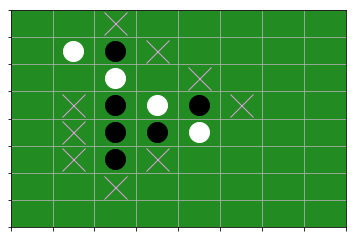

Game of Othello; Current Valid Moves are: [(1, 2), (2, 7), (3, 2), (1, 3), (5, 4), (4, 5), (2, 1), (1, 4), (3, 6)]
Your turn!


In [29]:
o.do_turn(2,2)

You moved!


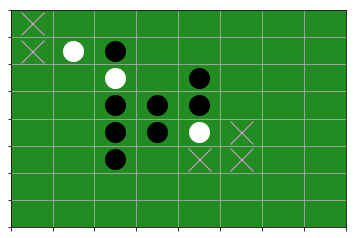

Game of Othello; Current Valid Moves are: [(4, 2), (0, 6), (5, 2), (0, 7), (5, 3)]
AI's Turn!
The AI concluded that (2, 1) is the best move.


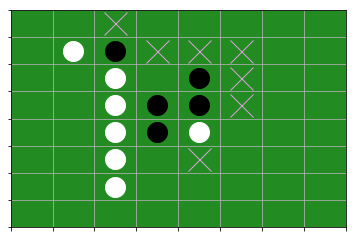

Game of Othello; Current Valid Moves are: [(2, 7), (5, 4), (5, 5), (4, 6), (5, 6), (3, 6), (4, 2)]
Your turn!


In [30]:
o.do_turn(4,5)

You moved!


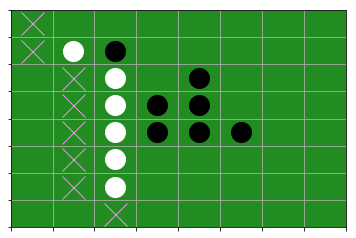

Game of Othello; Current Valid Moves are: [(1, 2), (1, 3), (1, 4), (0, 7), (0, 6), (1, 5), (2, 0), (1, 1)]
AI's Turn!
The AI concluded that (5, 2) is the best move.


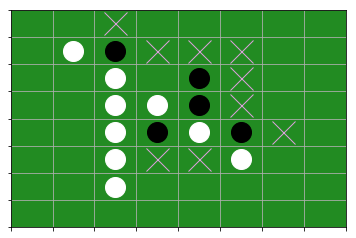

Game of Othello; Current Valid Moves are: [(2, 7), (3, 2), (5, 4), (4, 6), (5, 5), (5, 6), (6, 3), (3, 6), (4, 2)]
Your turn!


In [31]:
o.do_turn(5,3)

You moved!


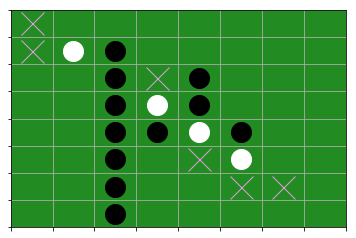

Game of Othello; Current Valid Moves are: [(5, 1), (6, 1), (0, 7), (0, 6), (4, 2), (3, 5)]
AI's Turn!
The AI concluded that (3, 6) is the best move.


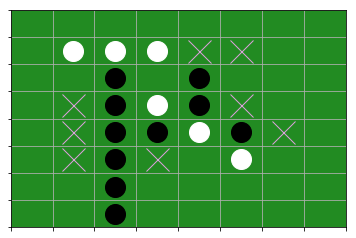

Game of Othello; Current Valid Moves are: [(1, 2), (5, 4), (3, 2), (1, 3), (4, 6), (5, 6), (1, 4), (6, 3)]
Your turn!


In [32]:
o.do_turn(2,0)

You moved!


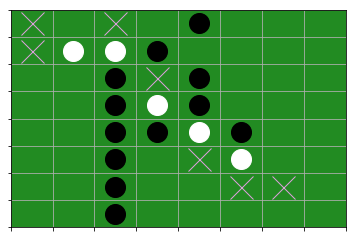

Game of Othello; Current Valid Moves are: [(2, 7), (6, 1), (0, 7), (0, 6), (4, 2), (5, 1), (3, 5)]
AI's Turn!
The AI concluded that (6, 3) is the best move.


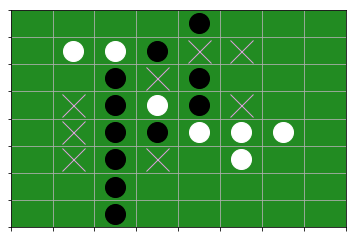

Game of Othello; Current Valid Moves are: [(1, 2), (3, 2), (1, 3), (5, 4), (4, 6), (5, 6), (1, 4), (3, 5)]
Your turn!


In [33]:
o.do_turn(4,7)

You moved!


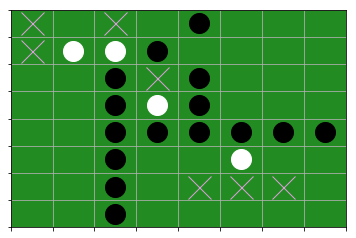

Game of Othello; Current Valid Moves are: [(2, 7), (6, 1), (0, 7), (0, 6), (5, 1), (4, 1), (3, 5)]
AI's Turn!
The AI concluded that (7, 4) is the best move.


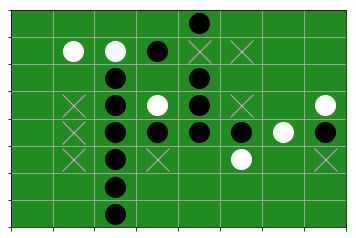

Game of Othello; Current Valid Moves are: [(1, 2), (5, 4), (3, 2), (1, 3), (4, 6), (5, 6), (1, 4), (7, 2)]
Your turn!


In [34]:
o.do_turn(7,3)

You moved!


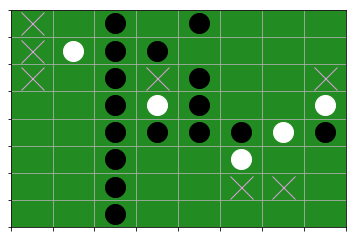

Game of Othello; Current Valid Moves are: [(6, 1), (0, 7), (0, 6), (7, 5), (0, 5), (5, 1), (3, 5)]
AI's Turn!
The AI concluded that (7, 2) is the best move.


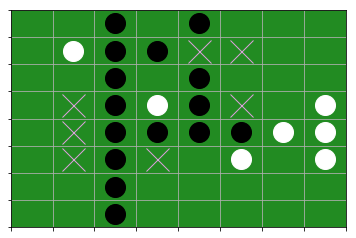

Game of Othello; Current Valid Moves are: [(1, 2), (5, 4), (3, 2), (1, 3), (4, 6), (5, 6), (1, 4)]
Your turn!


In [35]:
o.do_turn(2,7)

You moved!


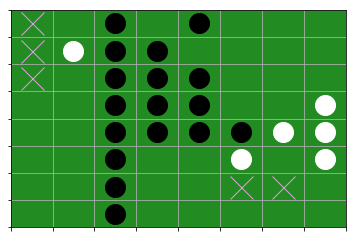

Game of Othello; Current Valid Moves are: [(0, 6), (5, 1), (0, 5), (6, 1), (0, 7)]
AI's Turn!
The AI concluded that (4, 6) is the best move.


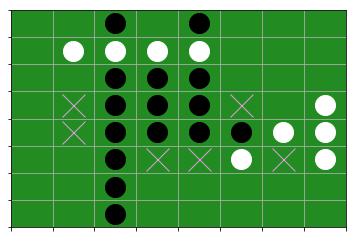

Game of Othello; Current Valid Moves are: [(5, 4), (3, 2), (1, 3), (1, 4), (6, 2), (4, 2)]
Your turn!


In [36]:
o.do_turn(3,5)

You moved!


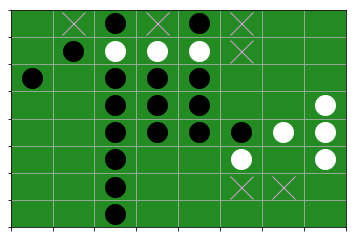

Game of Othello; Current Valid Moves are: [(5, 1), (5, 6), (6, 1), (5, 7), (1, 7), (3, 7)]
AI's Turn!
The AI concluded that (4, 2) is the best move.


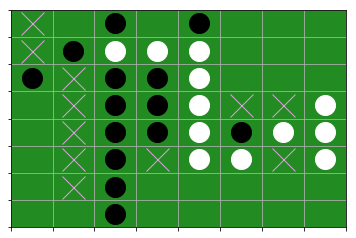

Game of Othello; Current Valid Moves are: [(1, 2), (6, 4), (3, 2), (1, 3), (5, 4), (1, 4), (0, 7), (0, 6), (1, 5), (6, 2), (1, 1)]
Your turn!


In [37]:
o.do_turn(0,5)

You moved!


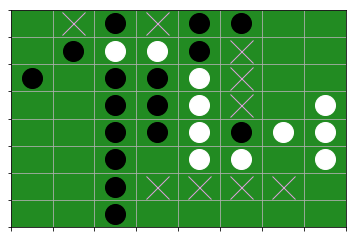

Game of Othello; Current Valid Moves are: [(5, 1), (5, 4), (5, 5), (5, 6), (6, 1), (3, 1), (1, 7), (3, 7), (4, 1)]
AI's Turn!
The AI concluded that (1, 1) is the best move.


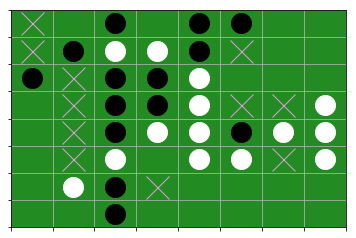

Game of Othello; Current Valid Moves are: [(1, 2), (6, 4), (5, 4), (1, 3), (5, 6), (3, 1), (1, 4), (0, 7), (0, 6), (1, 5), (6, 2)]
Your turn!


In [38]:
o.do_turn(5,7)

You moved!


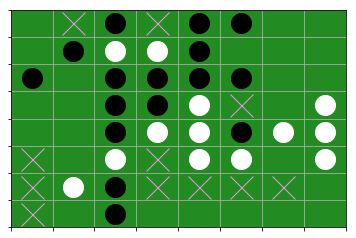

Game of Othello; Current Valid Moves are: [(0, 1), (3, 2), (0, 0), (5, 1), (5, 4), (6, 1), (3, 1), (1, 7), (3, 7), (4, 1), (0, 2)]
AI's Turn!
The AI concluded that (6, 2) is the best move.


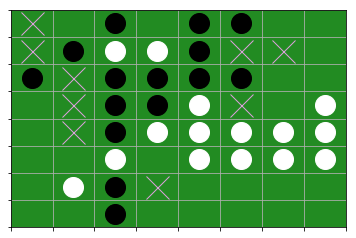

Game of Othello; Current Valid Moves are: [(5, 4), (1, 3), (6, 6), (5, 6), (3, 1), (1, 4), (0, 7), (0, 6), (1, 5)]
Your turn!


In [39]:
o.do_turn(5,5)

You moved!


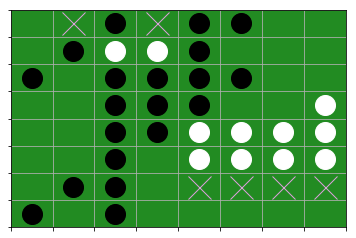

Game of Othello; Current Valid Moves are: [(5, 1), (7, 1), (6, 1), (1, 7), (3, 7), (4, 1)]
AI's Turn!
The AI concluded that (1, 5) is the best move.


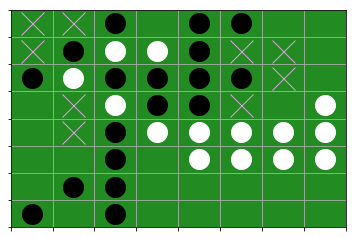

Game of Othello; Current Valid Moves are: [(5, 4), (1, 3), (6, 6), (5, 6), (1, 4), (0, 7), (0, 6), (1, 7), (6, 5)]
Your turn!


In [40]:
o.do_turn(0,0)

You moved!


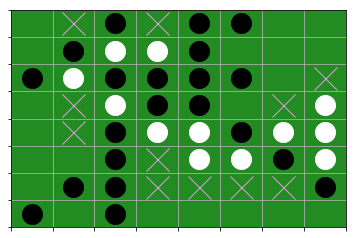

Game of Othello; Current Valid Moves are: [(6, 4), (3, 2), (1, 3), (5, 1), (6, 1), (3, 1), (1, 4), (7, 5), (1, 7), (3, 7), (4, 1)]
AI's Turn!
The AI concluded that (6, 5) is the best move.


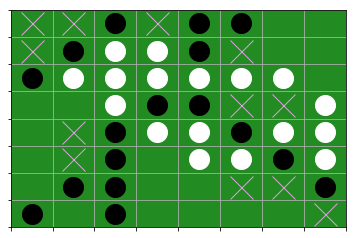

Game of Othello; Current Valid Moves are: [(1, 2), (6, 4), (5, 1), (1, 3), (5, 4), (7, 0), (5, 6), (6, 1), (0, 7), (0, 6), (1, 7), (3, 7)]
Your turn!


In [41]:
o.do_turn(7,1)

You moved!


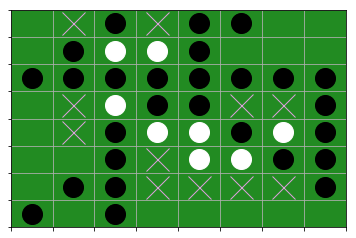

Game of Othello; Current Valid Moves are: [(6, 4), (3, 2), (1, 3), (5, 1), (5, 4), (6, 1), (3, 1), (1, 4), (1, 7), (3, 7), (4, 1)]
AI's Turn!
The AI concluded that (0, 4) is the best move.


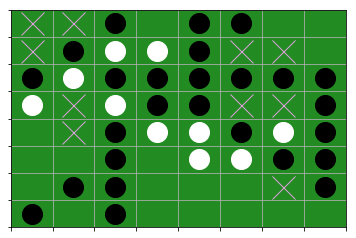

Game of Othello; Current Valid Moves are: [(6, 4), (5, 4), (1, 3), (6, 6), (5, 6), (6, 1), (1, 4), (0, 7), (0, 6), (1, 7)]
Your turn!


In [42]:
o.do_turn(7,5)

You moved!


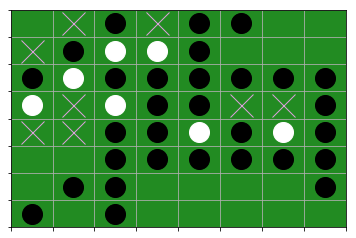

Game of Othello; Current Valid Moves are: [(6, 4), (5, 4), (1, 3), (1, 4), (0, 6), (1, 7), (3, 7), (0, 3)]
AI's Turn!
The AI concluded that (4, 1) is the best move.


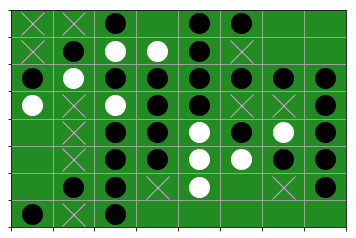

Game of Othello; Current Valid Moves are: [(1, 2), (6, 4), (5, 4), (1, 3), (5, 6), (6, 1), (3, 1), (1, 4), (0, 7), (0, 6), (1, 7), (1, 0)]
Your turn!


In [43]:
o.do_turn(3,2)